# Урок 6. Нейросети в обработке текста

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите какой результат вы получили? Что помогло вам улучшить ее точность?


In [1]:
import numpy as np
import pandas as pd
import re
from string import punctuation
from pymorphy2 import MorphAnalyzer
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')

def preprocess_text(txt):
    txt = str(txt)
    
    # пунктуация
    exclude = set(punctuation)
    
    # удяляем знаки пунктуации
    txt = "".join(c for c in txt if c not in exclude)
    
    #приводим все к нижнему регистру
    txt = txt.lower()
    
    # лематизация
    lemmatizer = WordNetLemmatizer()
    # использование: lemmatizer.lemmatize('dogs') -> dog
    txt = [lemmatizer.lemmatize(w) for w in txt.split() if w not in sw]
    return " ".join(txt)

def text_to_sequence(text, maxlen, vocabulary):
    # преобразование текста в последовательность
    result = []
    tokens = word_tokenize(text.lower())  #токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()]  # фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])  # если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result))  # нули дополняющие до maxlen
    return result[-maxlen:] + padding

class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()  # преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long()  # преобразуем в целочисленный тензор
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  # индексация данных
        y = self.target[index]  # индексация целевой переменной
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

class Net(nn.Module):
    # сверточная нейронная сеть
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
max_words = 2000
max_len = 20
num_classes = 1

# обучение
epochs = 10
batch_size = 512
print_batch_n = 100

dataset_train  = 'train.csv'
dataset_test  = 'test.csv'

data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')

data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
# всё на английском - нужны английские стоп слова
sw = set(stopwords.words('english'))


In [4]:
df_train, df_valid = train_test_split(data_train, test_size=0.2, random_state=42)

# переводим текст в данные
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].progress_apply(preprocess_text)
data_test['tweet'] = data_test['tweet'].progress_apply(preprocess_text)

# соединение всех обучающих данных в одну строку и приведение к нижнему регистру
train_row = " ".join(df_train["tweet"])
train_row = train_row.lower()

# разбиваем строку на слова
tokens = word_tokenize(train_row)
tokens[:10]

100%|██████████| 17197/17197 [00:00<00:00, 32753.77it/s]


['user',
 'user',
 'user',
 'ive',
 'paying',
 'attention',
 'past',
 'year8',
 'year',
 'he']

In [5]:
# оставляем только буквы или цифры
tokens_filtered = [word for word in tokens if word.isalnum()]

# частотное распределение
fdist = FreqDist(tokens_filtered)

# берём max_words самых частых слов
tokens_filtered_top = [pair[0] for pair in fdist.most_common(max_words-1)]  # -1 - padding
# инвертируем ранжирование по частоте (0 - самое частое)
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top)).items()}

In [8]:
x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["tweet"]])
x_valid = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_valid["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in data_test["tweet"]])

train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['label'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

model = Net(vocab_size=max_words)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model.train()
th = 0.5

train_loss_history = []
valid_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        
        # обучение
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
       
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        # статистику в процессе обучения
        if i % 150 == 0: 
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на тестовых данных
            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(valid_loader):
                test_labels = data[1]
                test_outputs = model(data[0])
                
                # подсчет ошибки на тесте
                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                test_running_total += len(data[1])
                pred_test_labels = torch.squeeze((test_outputs > th).int())
                test_running_right += (test_labels == pred_test_labels).sum()
            
            valid_loss_history.append(test_loss.item())
            print(f'Val loss: {test_loss:.3f}. Val acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Done')

Epoch [1/10]. Step [1/50]. Loss: 0.755. Acc: 0.090. Val loss: 0.623. Val acc: 0.929
Epoch [2/10]. Step [1/50]. Loss: 0.244. Acc: 0.920. Val loss: 0.061. Val acc: 0.929
Epoch [3/10]. Step [1/50]. Loss: 0.202. Acc: 0.926. Val loss: 0.087. Val acc: 0.929
Epoch [4/10]. Step [1/50]. Loss: 0.183. Acc: 0.930. Val loss: 0.001. Val acc: 0.929
Epoch [5/10]. Step [1/50]. Loss: 0.143. Acc: 0.930. Val loss: 0.040. Val acc: 0.934
Epoch [6/10]. Step [1/50]. Loss: 0.119. Acc: 0.949. Val loss: 0.235. Val acc: 0.945
Epoch [7/10]. Step [1/50]. Loss: 0.059. Acc: 0.975. Val loss: 0.189. Val acc: 0.949
Epoch [8/10]. Step [1/50]. Loss: 0.053. Acc: 0.986. Val loss: 0.005. Val acc: 0.948
Epoch [9/10]. Step [1/50]. Loss: 0.045. Acc: 0.988. Val loss: 0.000. Val acc: 0.945
Epoch [10/10]. Step [1/50]. Loss: 0.031. Acc: 0.992. Val loss: 0.000. Val acc: 0.947
Done


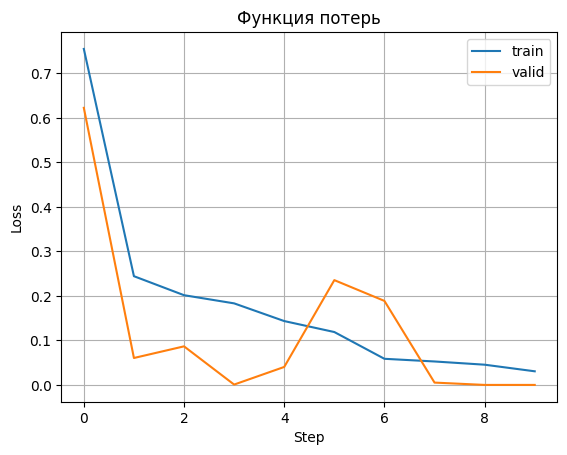

In [9]:
# функция потерь
plt.title('Функция потерь')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()